In [61]:
import pandas as pd
import os
import sklearn
import math
import joblib
from sklearn import tree
from sklearn import ensemble 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import impute
from sklearn import pipeline
from sklearn import compose
from sklearn import feature_selection
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics
from sklearn.compose import TransformedTargetRegressor
from feature_engine.selection import DropDuplicateFeatures, DropCorrelatedFeatures
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from shutil import rmtree

In [62]:
warnings.filterwarnings('ignore')
sklearn.set_config(display="diagram")
dir = "C:/Users/pc/Downloads/ai-level1/house-prices"
cachedir = os.path.join(dir, "pipeline_cache")

In [63]:
house_train = pd.read_csv(os.path.join(dir, "train.csv"))
house_train.shape
house_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [64]:
#Create new features
house_train['TotalSF'] = house_train['TotalBsmtSF'] + house_train['GrLivArea'] + house_train['1stFlrSF'] + house_train['2ndFlrSF']
house_train['TotalBathRooms'] = house_train['FullBath'] + house_train['BsmtFullBath'] + 0.5 * house_train['HalfBath'] +  0.5 * house_train['BsmtHalfBath']
house_train['TotalPorchSF'] = house_train['OpenPorchSF'] + house_train['3SsnPorch'] + house_train['EnclosedPorch'] + house_train['ScreenPorch']

In [65]:
def cont_selector(df):
    return df.select_dtypes(include=['number']).columns

def cat_selector(df):
    return df.select_dtypes(exclude=['number']).columns

def cast_to_cat(df, features):
    for feature in features:
        df[feature] = df[feature].astype('category')

In [66]:
print(cont_selector(house_train))
print(cat_selector(house_train))

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalSF', 'TotalBathRooms',
       'TotalPorchSF'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure',

In [67]:
features_to_cast = ["MSSubClass"]
features_to_cast.extend(cat_selector(house_train))
cast_to_cat(house_train, features_to_cast)
print(cont_selector(house_train))
print(cat_selector(house_train))

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'TotalSF', 'TotalBathRooms',
       'TotalPorchSF'],
      dtype='object')
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',

In [68]:
def get_features_to_drop_on_missingdata(df, threshold) :
    tmp = df.isnull().sum()
    return list(tmp[tmp/float(df.shape[0]) > threshold].index)

def drop_features(df, features):
    return df.drop(features, axis=1, inplace=True)

In [69]:
missing_data_features_to_drop = get_features_to_drop_on_missingdata(house_train, 0.25)
print(missing_data_features_to_drop)
drop_features(house_train, missing_data_features_to_drop)
house_train.info()

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1460 non-null   int64   
 1   MSSubClass      1460 non-null   category
 2   MSZoning        1460 non-null   category
 3   LotFrontage     1201 non-null   float64 
 4   LotArea         1460 non-null   int64   
 5   Street          1460 non-null   category
 6   LotShape        1460 non-null   category
 7   LandContour     1460 non-null   category
 8   Utilities       1460 non-null   category
 9   LotConfig       1460 non-null   category
 10  LandSlope       1460 non-null   category
 11  Neighborhood    1460 non-null   category
 12  Condition1      1460 non-null   category
 13  Condition2      1460 non-null   category
 14  BldgType        1460 non-null   category
 15  HouseStyle      1460 non-null   c

In [70]:
target = house_train['SalePrice']
features_to_drop = ['Id', 'SalePrice']
drop_features(house_train, features_to_drop)
house_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   MSSubClass      1460 non-null   category
 1   MSZoning        1460 non-null   category
 2   LotFrontage     1201 non-null   float64 
 3   LotArea         1460 non-null   int64   
 4   Street          1460 non-null   category
 5   LotShape        1460 non-null   category
 6   LandContour     1460 non-null   category
 7   Utilities       1460 non-null   category
 8   LotConfig       1460 non-null   category
 9   LandSlope       1460 non-null   category
 10  Neighborhood    1460 non-null   category
 11  Condition1      1460 non-null   category
 12  Condition2      1460 non-null   category
 13  BldgType        1460 non-null   category
 14  HouseStyle      1460 non-null   category
 15  OverallQual     1460 non-null   int64   
 16  OverallCond     1460 non-null   int64   
 17  YearBuilt     

In [71]:
#define train, target data and metric
X_train = house_train
y_train = target
scoring = metrics.make_scorer(metrics.root_mean_squared_log_error, greater_is_better=False)

In [72]:
#preprocessing pipeline for tree estimators
steps = [('imp', impute.SimpleImputer(strategy="most_frequent")), 
         ('ord_enc', preprocessing.OrdinalEncoder(
                        handle_unknown="use_encoded_value",
                        unknown_value=-1,
                        encoded_missing_value=-2))
        ]
cat_tree_preprocessor = pipeline.Pipeline(steps)

steps = [('imp', impute.SimpleImputer())]
cont_tree_preprocessor = pipeline.Pipeline(steps)

tree_preprocessor = compose.ColumnTransformer(
    [ ("categorical", cat_tree_preprocessor, cat_selector(house_train)), ("continuous", cont_tree_preprocessor, cont_selector(house_train)) ]
)

In [73]:
#dt pipeline-I
dt_pipeline1 = pipeline.Pipeline([  
                    ('tree_preprocessor', tree_preprocessor),
                    ('zv_filter', feature_selection.VarianceThreshold()),
                    ('dt', tree.DecisionTreeRegressor())
                ], memory=cachedir)
dt_pipeline1

Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('tree_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_enc',
                                                                   OrdinalEncoder(encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['MSSubClass', 'MSZo...
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotalSF', 'TotalBathRooms', 'TotalPorchSF'],
      dtype='object'))])),
                ('zv_filter', VarianceThreshold()),
                ('dt', DecisionTreeRegressor())])

In [74]:
#grid search of dt pipeline-I
dt_pipeline_params = {
            'dt__max_depth' : [3, 4, 5, 6, 7, 8, 9, 10],
            'dt__min_samples_split': [2, 3, 10],
            'dt__min_samples_leaf': [1, 3, 10],
        }
cv = model_selection.KFold(10)
dt_pipeline_grid1 = model_selection.GridSearchCV(dt_pipeline1, dt_pipeline_params, cv=cv, scoring=scoring, n_jobs=4)
dt_pipeline_grid1.fit(X_train, y_train)
print(dt_pipeline_grid1.best_params_)
print(dt_pipeline_grid1.best_score_)
print(dt_pipeline_grid1.best_estimator_)

{'dt__max_depth': 8, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 10}
-0.17645274603505548
Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('tree_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_enc',
                                                                   OrdinalEncoder(encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['MSSubClass', 'MSZo...
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplac

In [75]:
#dt pipeline-II
target_transformer = preprocessing.PowerTransformer(method='box-cox')

dt_with_trans_target = TransformedTargetRegressor(
    regressor = tree.DecisionTreeRegressor(),
    transformer= target_transformer
)
dt_pipeline2 = pipeline.Pipeline([  
                    ('tree_preprocessor', tree_preprocessor),
                    ('zv_filter', feature_selection.VarianceThreshold()),
                    ('dt', dt_with_trans_target)
                ], memory=cachedir)
dt_pipeline2

Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('tree_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_enc',
                                                                   OrdinalEncoder(encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['MSSubClass', 'MSZo...
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotalSF', 'TotalBathRooms', 'TotalPorchSF'],
      dtype='object'))])),
                ('zv_filter', VarianceThreshold()),
                ('dt',
                 TransformedTargetRegressor(regressor=DecisionTreeRegressor(),
                                            transformer=PowerTransformer(method='box-cox')))])

In [76]:
#grid search of dt pipeline-II
dt_pipeline_params = {
            'dt__regressor__max_depth' : [3, 4, 5, 6, 7, 8, 9, 10],
            'dt__regressor__min_samples_split': [2, 3, 10],
            'dt__regressor__min_samples_leaf': [1, 3, 10],
        }
cv = model_selection.KFold(10)
dt_pipeline_grid2 = model_selection.GridSearchCV(dt_pipeline2, dt_pipeline_params, cv=cv, scoring=scoring, n_jobs=4)
dt_pipeline_grid2.fit(X_train, y_train)
print(dt_pipeline_grid2.best_params_)
print(dt_pipeline_grid2.best_score_)
print(dt_pipeline_grid2.best_estimator_)

{'dt__regressor__max_depth': 8, 'dt__regressor__min_samples_leaf': 10, 'dt__regressor__min_samples_split': 10}
-0.1772202533532653
Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('tree_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_enc',
                                                                   OrdinalEncoder(encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['MSSubClass', 'MSZo...
       'GarageC

In [86]:
#rf pipeline-I 
rf_pipeline1 = pipeline.Pipeline([  
                    ('tree_preprocessor', tree_preprocessor),
                    ('zv_filter', feature_selection.VarianceThreshold()),
                    ('rf', ensemble.RandomForestRegressor())
                ], memory=cachedir)
rf_pipeline1

Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('tree_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_enc',
                                                                   OrdinalEncoder(encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['MSSubClass', 'MSZo...
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotalSF', 'TotalBathRooms', 'TotalPorchSF'],
      dtype='object'))])),
                ('zv_filter', VarianceThreshold()),
                ('rf', RandomForestRegressor())])

In [87]:
#grid search of rf pipeline-I 
rf_pipeline_params = {
            'rf__max_depth' : [4, 6, 8],
            'rf__n_estimators': [50, 10],
            'rf__max_features': ['sqrt', 'auto', 'log2'],
            'rf__min_samples_split': [2, 3, 10],
            'rf__min_samples_leaf': [1, 3, 10],
            'rf__bootstrap': [True, False]
        }
cv = model_selection.KFold(10)
rf_pipeline_grid1 = model_selection.GridSearchCV(rf_pipeline1, rf_pipeline_params, cv=cv, scoring=scoring, n_jobs=4)
rf_pipeline_grid1.fit(X_train, y_train)
print(rf_pipeline_grid1.best_params_)
print(rf_pipeline_grid1.best_score_)
print(rf_pipeline_grid1.best_estimator_)

{'rf__bootstrap': False, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
-0.1471315463961145
Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('tree_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_enc',
                                                                   OrdinalEncoder(encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Inde

In [88]:
#rf pipeline-II
target_transformer = preprocessing.PowerTransformer(method='box-cox')

rf_with_trans_target = TransformedTargetRegressor(
    regressor = ensemble.RandomForestRegressor(),
    transformer= target_transformer
)
rf_pipeline2 = pipeline.Pipeline([  
                    ('tree_preprocessor', tree_preprocessor),
                    ('zv_filter', feature_selection.VarianceThreshold()),
                    ('rf', rf_with_trans_target)
                ], memory=cachedir)
rf_pipeline2

Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('tree_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_enc',
                                                                   OrdinalEncoder(encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['MSSubClass', 'MSZo...
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TotalSF', 'TotalBathRooms', 'TotalPorchSF'],
      dtype='object'))])),
                ('zv_filter', VarianceThreshold()),
                ('rf',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                            transformer=PowerTransformer(method='box-cox')))])

In [89]:
#grid search of rf pipeline-II
rf_pipeline_params = {
            'rf__regressor__max_depth' : [4, 6, 8],
            'rf__regressor__n_estimators': [50, 10],
            'rf__regressor__max_features': ['sqrt', 'auto', 'log2'],
            'rf__regressor__min_samples_split': [2, 3, 10],
            'rf__regressor__min_samples_leaf': [1, 3, 10],
            'rf__regressor__bootstrap': [True, False]
        }
cv = model_selection.KFold(10)
rf_pipeline_grid2 = model_selection.GridSearchCV(rf_pipeline2, rf_pipeline_params, cv=cv, scoring=scoring, n_jobs=4)
rf_pipeline_grid2.fit(X_train, y_train)
print(rf_pipeline_grid2.best_params_)
print(rf_pipeline_grid2.best_score_)
print(rf_pipeline_grid2.best_estimator_)

{'rf__regressor__bootstrap': False, 'rf__regressor__max_depth': 8, 'rf__regressor__max_features': 'sqrt', 'rf__regressor__min_samples_leaf': 1, 'rf__regressor__min_samples_split': 10, 'rf__regressor__n_estimators': 50}
-0.14046855176763948
Pipeline(memory='C:/Users/pc/Downloads/ai-level1/house-prices\\pipeline_cache',
         steps=[('tree_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_enc',
                                                                   OrdinalEncoder(encoded_missing_value=-2,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_

In [92]:
feature_names = rf_pipeline_grid2.best_estimator_[0].get_feature_names_out()
print(len(feature_names), feature_names)
feature_names = rf_pipeline_grid2.best_estimator_[1].get_feature_names_out(input_features = feature_names)
print(len(feature_names), feature_names)

76 ['categorical__MSSubClass' 'categorical__MSZoning' 'categorical__Street'
 'categorical__LotShape' 'categorical__LandContour'
 'categorical__Utilities' 'categorical__LotConfig'
 'categorical__LandSlope' 'categorical__Neighborhood'
 'categorical__Condition1' 'categorical__Condition2'
 'categorical__BldgType' 'categorical__HouseStyle'
 'categorical__RoofStyle' 'categorical__RoofMatl'
 'categorical__Exterior1st' 'categorical__Exterior2nd'
 'categorical__ExterQual' 'categorical__ExterCond'
 'categorical__Foundation' 'categorical__BsmtQual' 'categorical__BsmtCond'
 'categorical__BsmtExposure' 'categorical__BsmtFinType1'
 'categorical__BsmtFinType2' 'categorical__Heating'
 'categorical__HeatingQC' 'categorical__CentralAir'
 'categorical__Electrical' 'categorical__KitchenQual'
 'categorical__Functional' 'categorical__GarageType'
 'categorical__GarageFinish' 'categorical__GarageQual'
 'categorical__GarageCond' 'categorical__PavedDrive'
 'categorical__SaleType' 'categorical__SaleCondition'
 '

,importance
feature,
categorical__LandContour,0.001001
categorical__Exterior2nd,0.001057
categorical__ExterCond,0.001160
categorical__Electrical,0.001189
continuous__MoSold,0.001240
continuous__KitchenAbvGr,0.001287
categorical__Exterior1st,0.001778
categorical__SaleCondition,0.001820
continuous__BsmtFullBath,0.002277


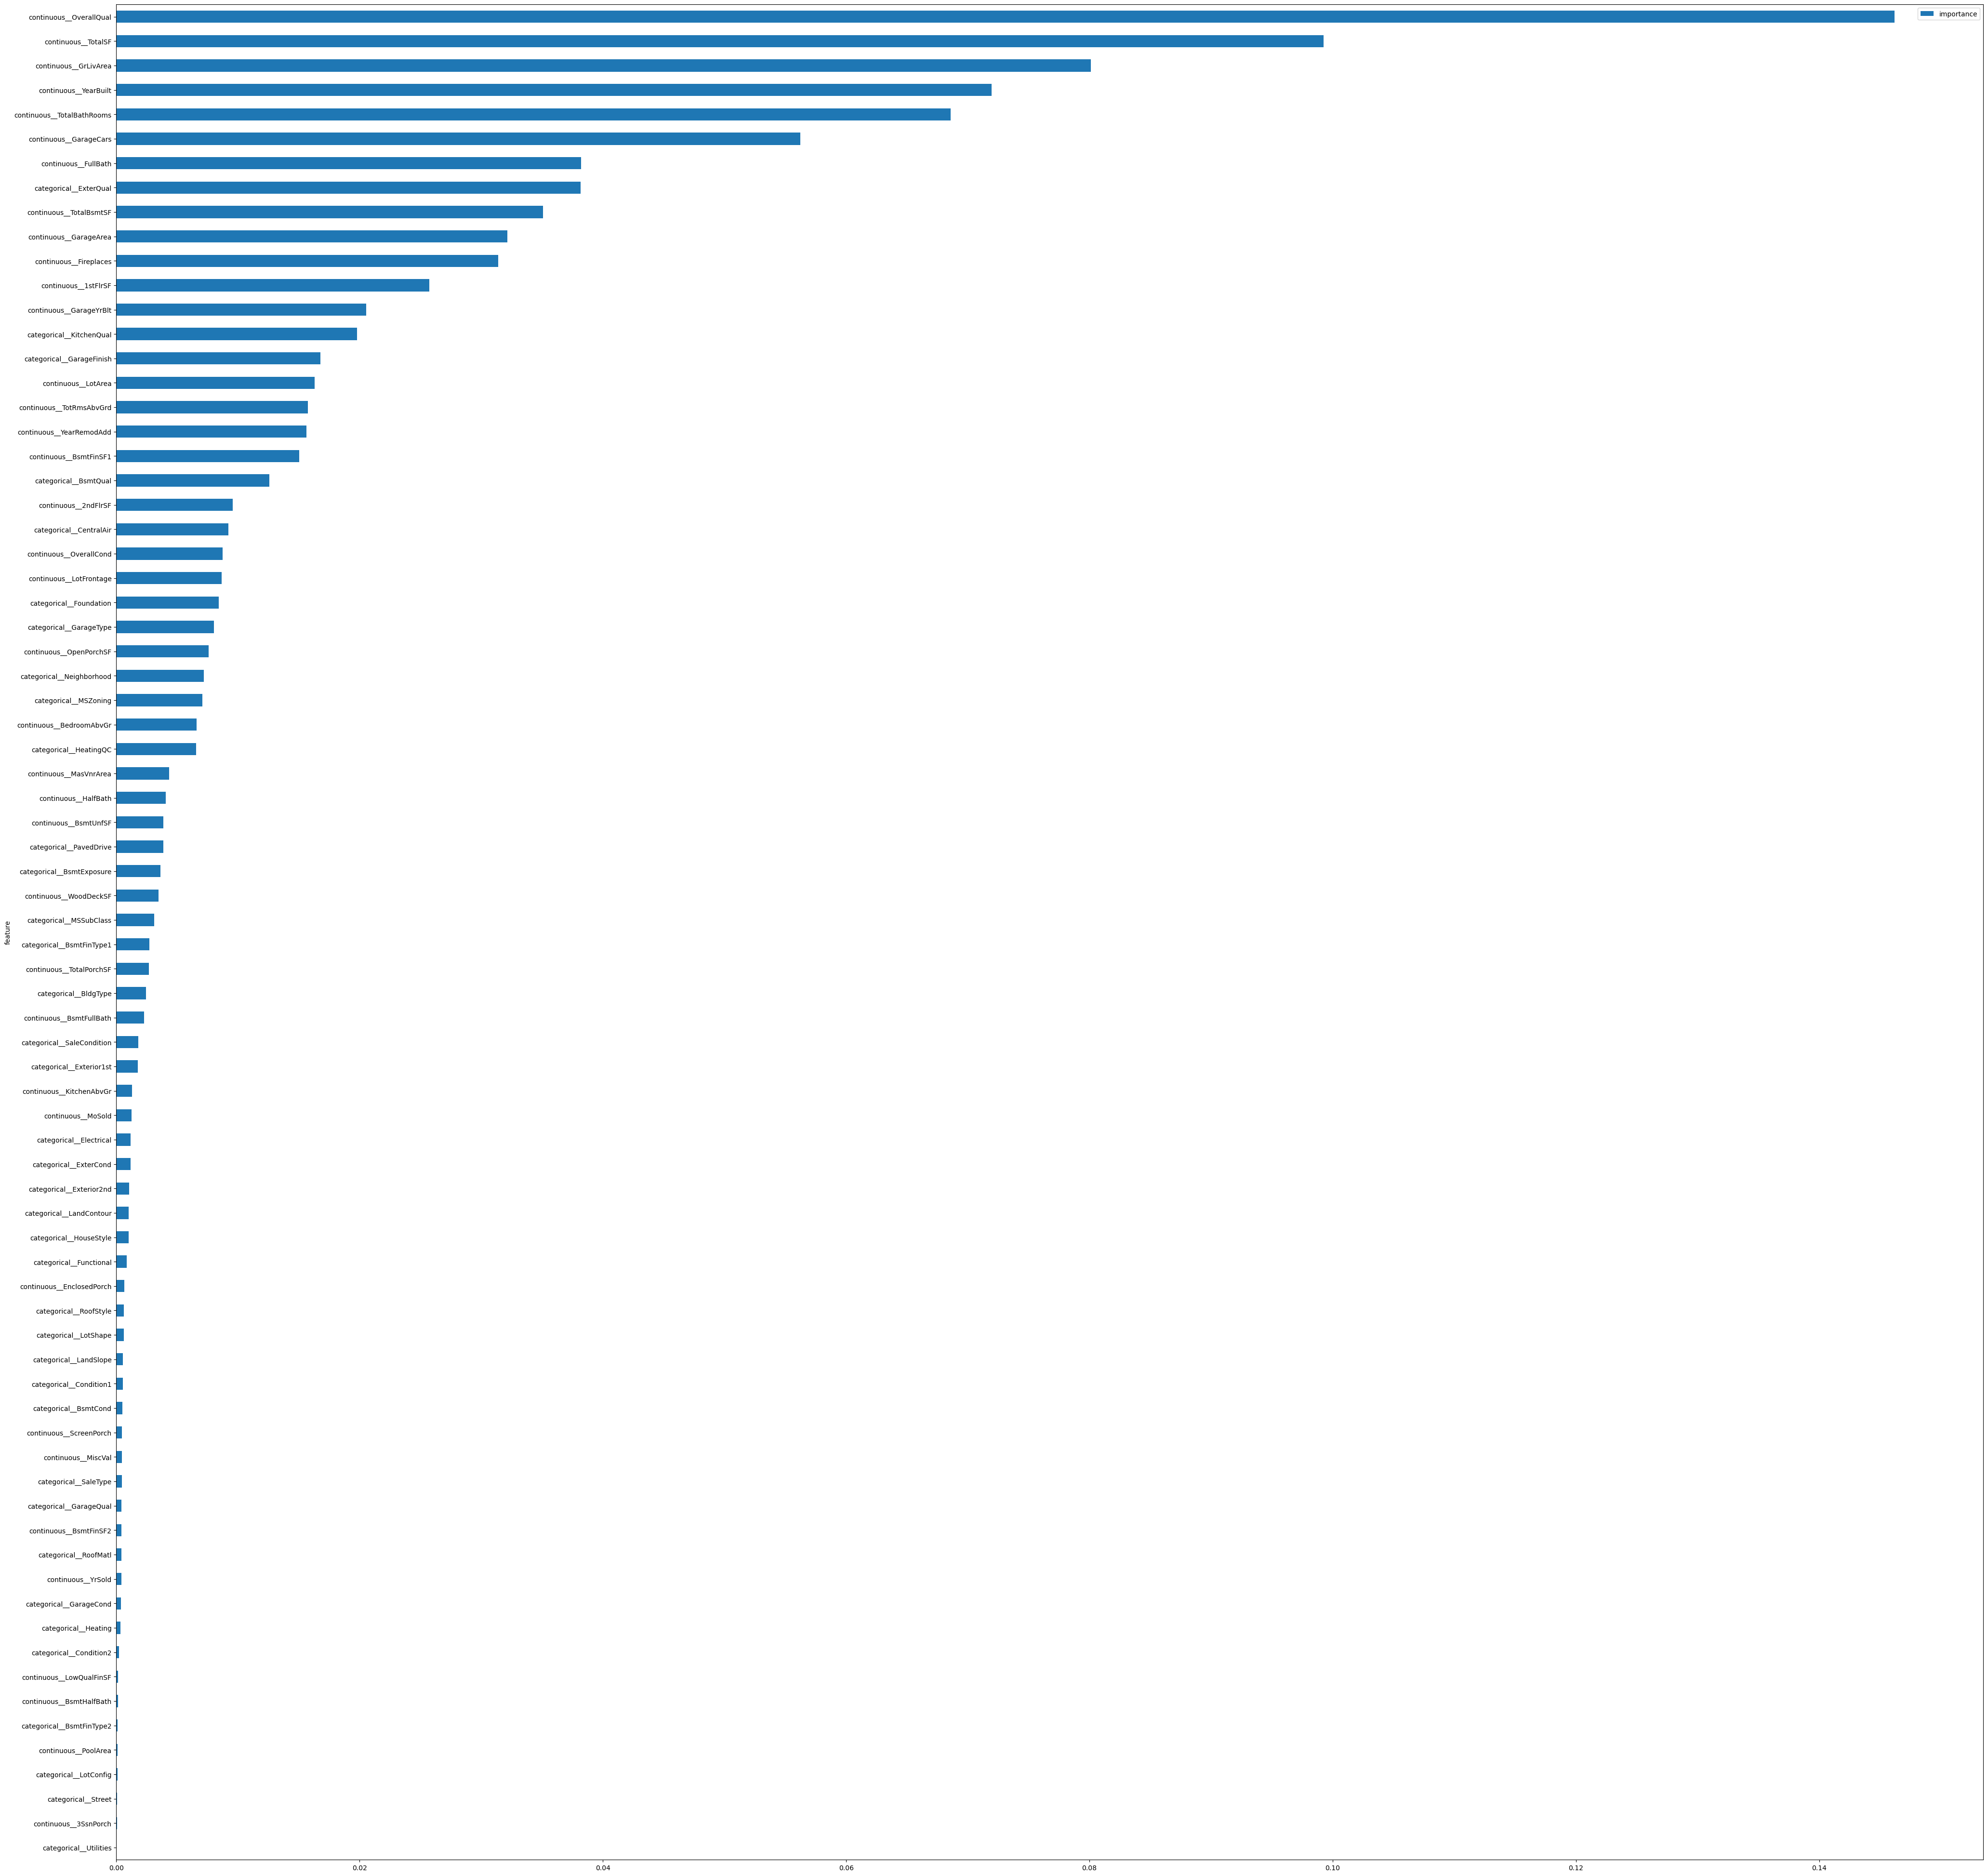

In [95]:
def plot_feature_importances(model, feature_names):
    features = pd.DataFrame({'feature': feature_names, 'importance':model.feature_importances_})
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    features.plot(kind='barh', figsize=(50, 50))
    return features
    
tmp = plot_feature_importances(rf_pipeline_grid2.best_estimator_[2].regressor_, feature_names)
tmp.tail(50)

In [96]:
joblib.dump(dt_pipeline_grid2.best_estimator_, os.path.join(dir, "houseprice_dt.pkl"))
joblib.dump(rf_pipeline_grid2.best_estimator_, os.path.join(dir, "houseprice_rf.pkl"))

['C:/Users/pc/Downloads/ai-level1/house-prices\\houseprice_rf.pkl']

In [77]:
house_test = pd.read_csv(os.path.join(dir, "test.csv"))
print(house_test.shape)
house_test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [78]:
#Create new features
house_test['TotalSF'] = house_test['TotalBsmtSF'] + house_test['GrLivArea'] + house_test['1stFlrSF'] + house_train['2ndFlrSF']
house_test['TotalBathRooms'] = house_test['FullBath'] + house_test['BsmtFullBath'] + 0.5 * house_test['HalfBath'] +  0.5 * house_test['BsmtHalfBath']
house_test['TotalPorchSF'] = house_test['OpenPorchSF'] + house_test['3SsnPorch'] + house_test['EnclosedPorch'] + house_test['ScreenPorch']

In [79]:
cast_to_cat(house_test, features_to_cast)

In [80]:
house_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              1459 non-null   int64   
 1   MSSubClass      1459 non-null   category
 2   MSZoning        1455 non-null   category
 3   LotFrontage     1232 non-null   float64 
 4   LotArea         1459 non-null   int64   
 5   Street          1459 non-null   category
 6   Alley           107 non-null    category
 7   LotShape        1459 non-null   category
 8   LandContour     1459 non-null   category
 9   Utilities       1457 non-null   category
 10  LotConfig       1459 non-null   category
 11  LandSlope       1459 non-null   category
 12  Neighborhood    1459 non-null   category
 13  Condition1      1459 non-null   category
 14  Condition2      1459 non-null   category
 15  BldgType        1459 non-null   category
 16  HouseStyle      1459 non-null   category
 17  OverallQual   

In [81]:
drop_features(house_test, missing_data_features_to_drop)

In [90]:
house_test['SalePrice'] = np.round(rf_pipeline_grid2.best_estimator_.predict(house_test), 2)
house_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,TotalBathRooms,TotalPorchSF,SalePrice
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,6,2010,WD,Normal,3528.0,1.0,120,126558.78
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,12500,6,2010,WD,Normal,3987.0,1.5,36,148484.33
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,3,2010,WD,Normal,4351.0,2.5,34,175991.98
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,0,0,6,2010,WD,Normal,4212.0,2.5,36,183128.61
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,0,0,1,2010,WD,Normal,4893.0,2.0,226,195269.55


In [91]:
house_test.to_csv(os.path.join(dir, "house_prices_submit.csv"), columns=["Id", "SalePrice"], index=False)

In [92]:
rmtree(cachedir)